# Centroid alignment using Xopt/BAX

# Imports

In [1]:
# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('C:\\Users\\Dylan\\SLAC') #parent directory containing emitopt module

import matplotlib.pyplot as plt
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import pandas as pd
import torch

from xopt import Xopt
from xopt.vocs import VOCS
from xopt.generators.bayesian.bax_generator import BaxGenerator
from xopt.generators.bayesian.expected_improvement import ExpectedImprovementGenerator

from xopt.evaluator import Evaluator

import time
import numpy as np
import random

# Use CUDA if available

In [2]:
# if torch.cuda.is_available():
if False:
    torch.set_default_tensor_type('torch.cuda.DoubleTensor')
    use_cuda = True
else:
    torch.set_default_tensor_type('torch.DoubleTensor')
    use_cuda = False

In [3]:
torch.get_default_dtype()

torch.float64

# Notebook settings

In [4]:
noise = False #whether to add noise to the ground-truth beam size function outputs
n_obs_init = 3 #number of random initial observations for GP model
n_samples = 100 #number of posterior samples for BAX
rand_seed = 0

#random seeds for reproducibility 
torch.manual_seed(rand_seed)
np.random.seed(rand_seed) #only affects initial random observations through Xopt
random.seed(rand_seed)

# Build test function from single-quadrupole optical beam size model 
Here we define a simple ground-truth beam size function for our optimization problem, where we attempt to find the location in tuning parameter space with minimal emittance. Note that the function "test_func" used to evaluate the ground-truth beam size function takes a dictionary as input and returns a dictionary as the output.

In [5]:
# define test functions
var_names = ['x0', 'x1']

def centroid_position_at_screen(x):
    r0 = 0.0
    cpas = (r0 + x[:,0]) + (r0 + x[:,0])*x[:,1]
    
#     return cpas * (1. + .1*torch.randn_like(cpas))
    return cpas 

def test_func(input_dict):
    x0 = torch.tensor(input_dict['x0']).reshape(-1,1)
    x1 = torch.tensor(input_dict['x1']).reshape(-1,1)
    x = torch.cat((x0, x1), dim=1)
    return {'y': float(centroid_position_at_screen(x).squeeze().cpu().numpy())}

# Construct vocs

In [6]:
variables = {var_name: [-2,2] for var_name in var_names}

#construct vocs
vocs = VOCS(
    variables = variables,
    objectives = {'y':"MINIMIZE"}
)

print('variable_names =', vocs.variable_names)
print('domain =\n', vocs.bounds.T)

variable_names = ['x0', 'x1']
domain =
 [[-2.  2.]
 [-2.  2.]]


# Prepare generator options.
In this example, we use a specialty covariance module (Linear ProductKernel) for our beam size model.

In [7]:
from gpytorch.kernels import MaternKernel, PolynomialKernel, ScaleKernel
from xopt.generators.bayesian.models.standard import StandardModelConstructor
from gpytorch.priors.torch_priors import GammaPrior
from xopt.generators.bayesian.bax_generator import BaxGenerator

from emitopt.algorithms import ScipyBeamAlignment

# prepare custom covariance module
# covar_module = PolynomialKernel(power=1)
covar_module = PolynomialKernel(power=1, active_dims=[0]) * PolynomialKernel(power=1, active_dims=[1])
scaled_covar_module = ScaleKernel(covar_module)   
    
# prepare options for Xopt generator
covar_module_dict = {'y': scaled_covar_module}
# covar_module_dict = {}
model_constructor = StandardModelConstructor(covar_modules=covar_module_dict, use_low_noise_prior=True)

algo = ScipyBeamAlignment(meas_dims=[1], n_samples=n_samples)

# Construct generator, evaluator, Xopt objects

In [8]:
#construct BAX generator
generator = BaxGenerator(vocs=vocs, model_constructor=model_constructor, algorithm=algo, use_cuda=use_cuda)
# generator = ExpectedImprovementGenerator(vocs, generator_options)

#construct evaluator
evaluator = Evaluator(function=test_func)

#construct Xopt optimizer
optimizer = Xopt(evaluator=evaluator, generator=generator, vocs=vocs)

In [9]:
optimizer.random_evaluate(n_obs_init)

,x0,x1,y,xopt_runtime,xopt_error
1,-0.195254,-0.179533,-0.160200,0.000972,False
2,-0.860757,0.305381,-1.123616,0.000114,False
3,-0.411054,-0.583576,-0.171172,0.000079,False


In [10]:
optimizer.data

,x0,x1,y,xopt_runtime,xopt_error
1,-0.195254,-0.179533,-0.160200,0.000972,False
2,-0.860757,0.305381,-1.123616,0.000114,False
3,-0.411054,-0.583576,-0.171172,0.000079,False


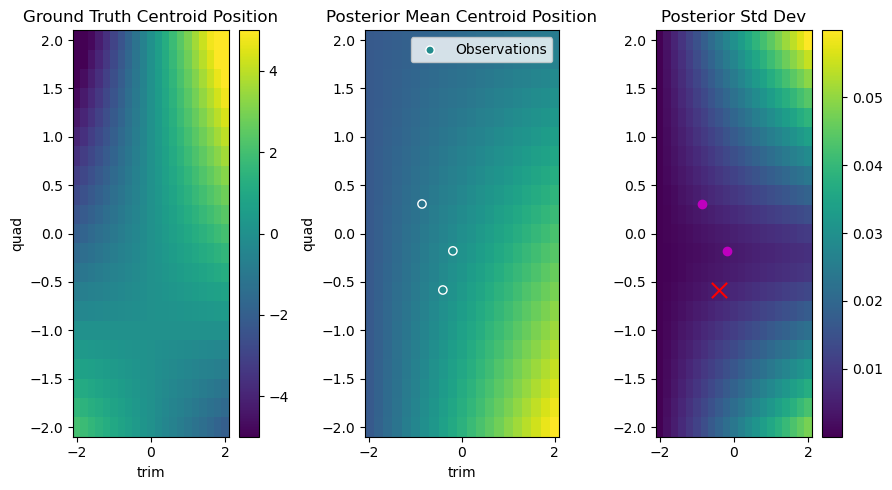

In [11]:
beam_centroid_model = optimizer.generator.train_model().models[0]

ls = torch.linspace(-2,2,21)
x0, x1 = torch.meshgrid(ls, ls)
xmesh_serialized = torch.cat((x0.reshape(-1,1), x1.reshape(-1,1)), dim=1)
ymesh_model = beam_centroid_model.posterior(xmesh_serialized).mean.reshape(21,21).detach()
ymesh_model_var = beam_centroid_model.posterior(xmesh_serialized).variance.reshape(21,21).detach()
ymesh_gt = centroid_position_at_screen(xmesh_serialized).reshape(21,21).detach()

fig, axs = plt.subplots(1,3)
fig.set_size_inches(9,5)

ax = axs[0]
c = ax.pcolormesh(x0, x1, ymesh_gt, vmin=-5, vmax=5)
fig.colorbar(c)
ax.set_xlabel('trim')
ax.set_ylabel('quad')
ax.set_title('Ground Truth Centroid Position')

ax = axs[1]
ax.pcolormesh(x0, x1, ymesh_model, vmin=-5, vmax=5)
ax.set_xlabel('trim')
ax.set_ylabel('quad')
ax.set_title('Posterior Mean Centroid Position')
ax.scatter(optimizer.data['x0'], optimizer.data['x1'], c=optimizer.data['y'],
           vmin=-5, vmax=5, edgecolors='w', label='Observations')
ax.legend()

ax = axs[2]
c = ax.pcolormesh(x0, x1, ymesh_model_var.sqrt())
fig.colorbar(c)

# for x_star in X_stars:
#     ax.axvline(float(x_star), ymax=0.1, c='r')
    
ax.scatter(optimizer.data['x0'][:-1], optimizer.data['x1'][:-1], c='m', label='Observations')
ax.scatter(optimizer.data['x0'][-1:], optimizer.data['x1'][-1:], c='r', marker='x', s=120)
ax.set_title('Posterior Std Dev')

plt.tight_layout()



Iteration 0 



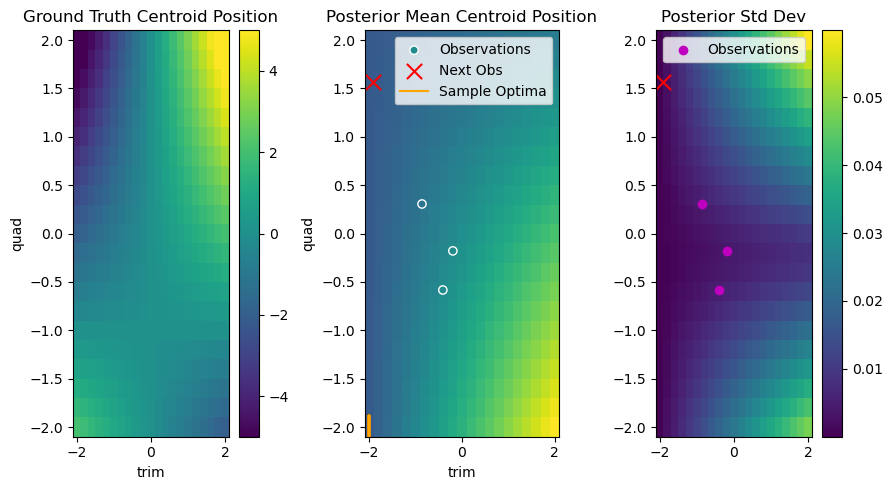

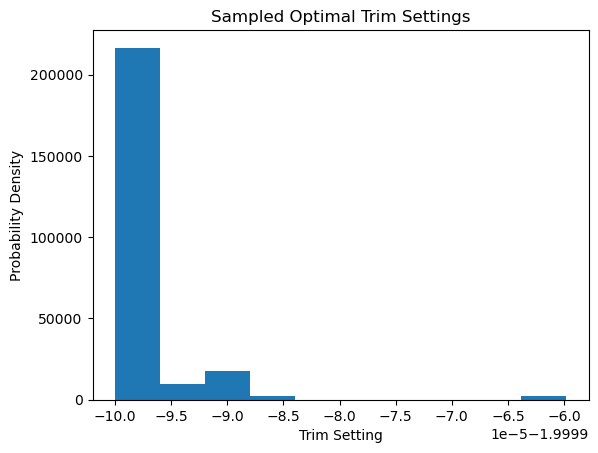



Iteration 1 



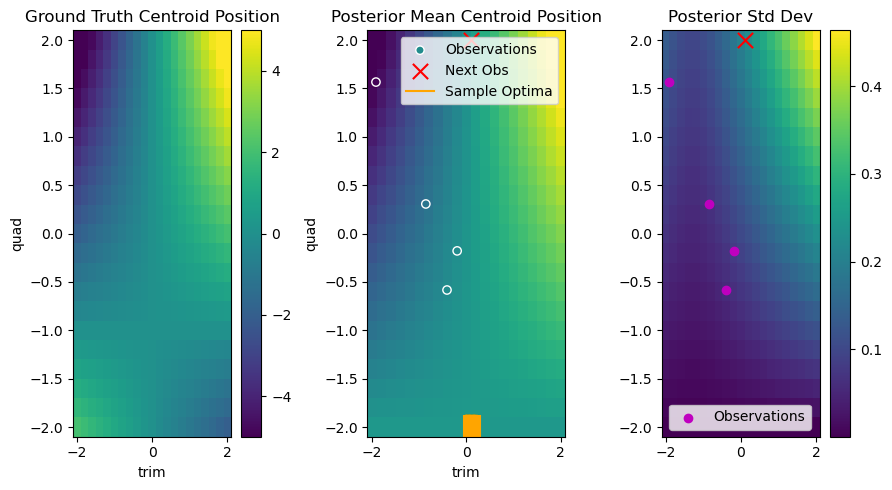

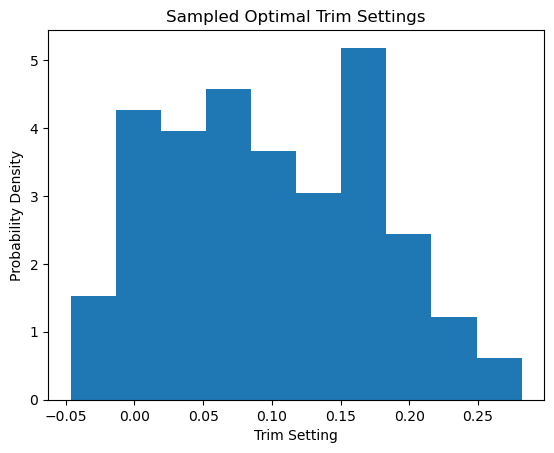



Iteration 2 



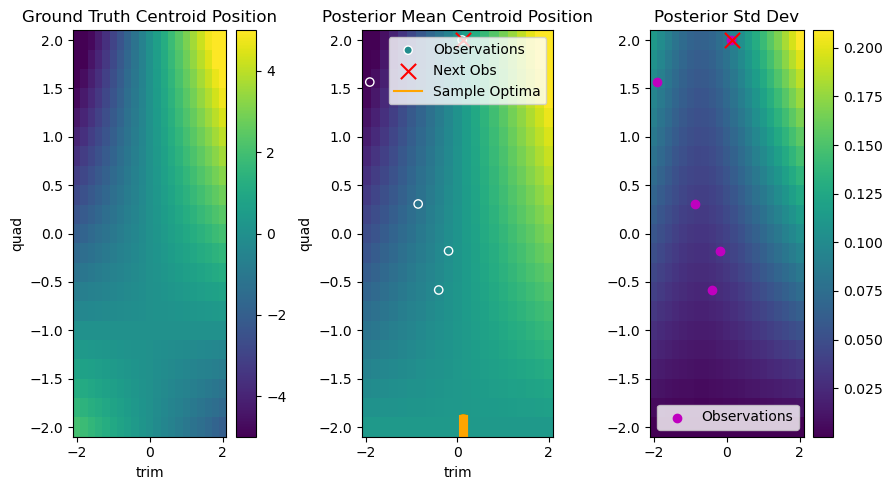

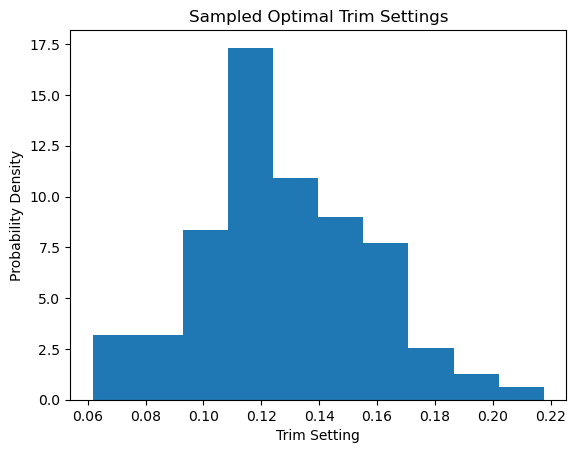



Iteration 3 



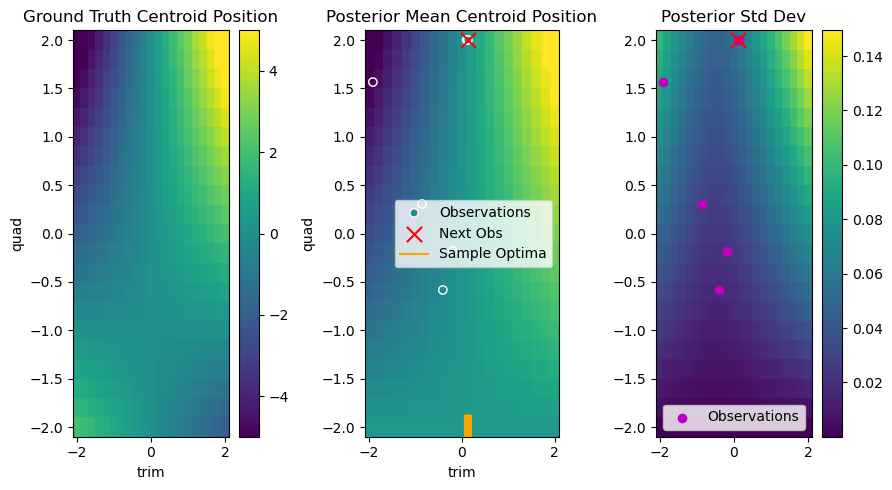

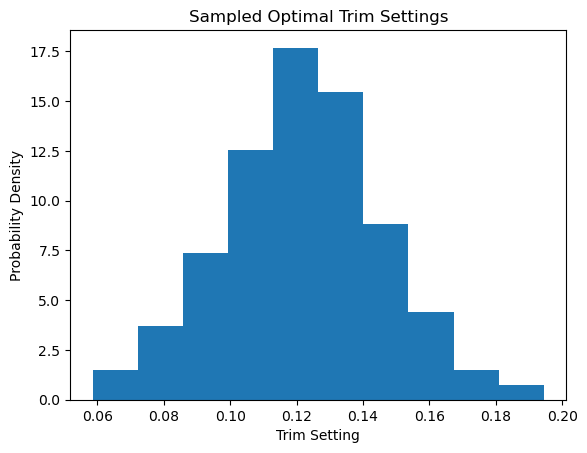



Iteration 4 



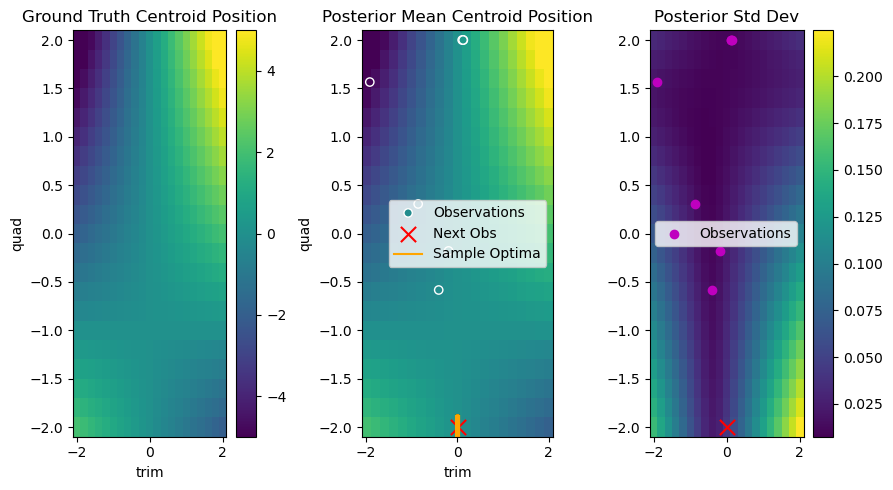

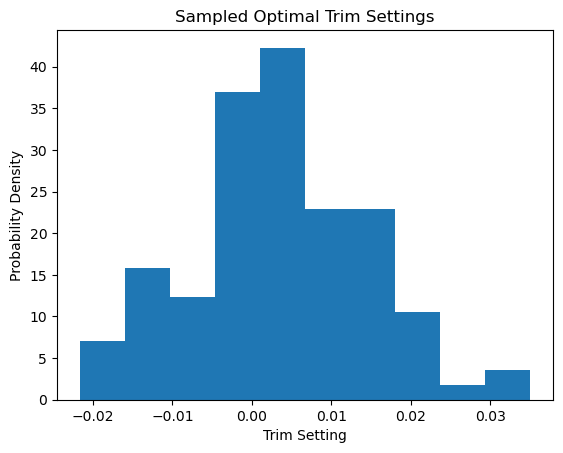



Iteration 5 



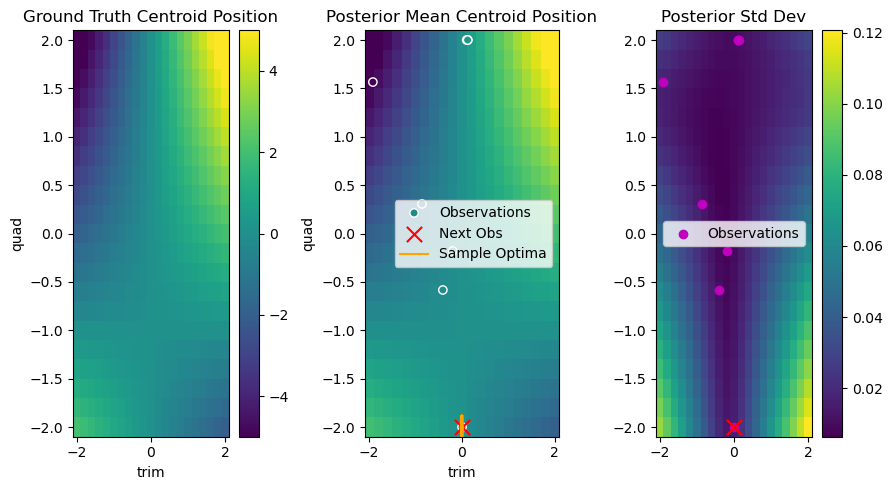

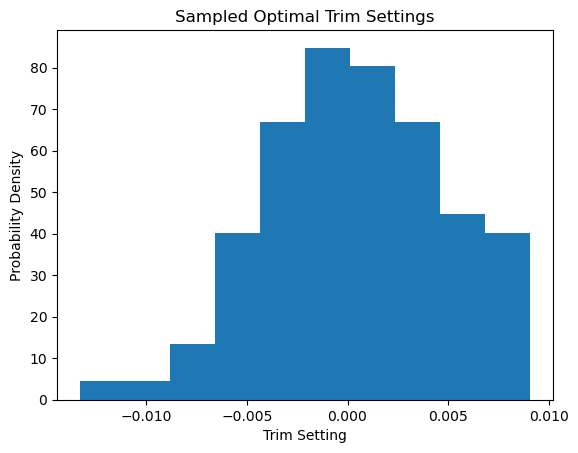



Iteration 6 



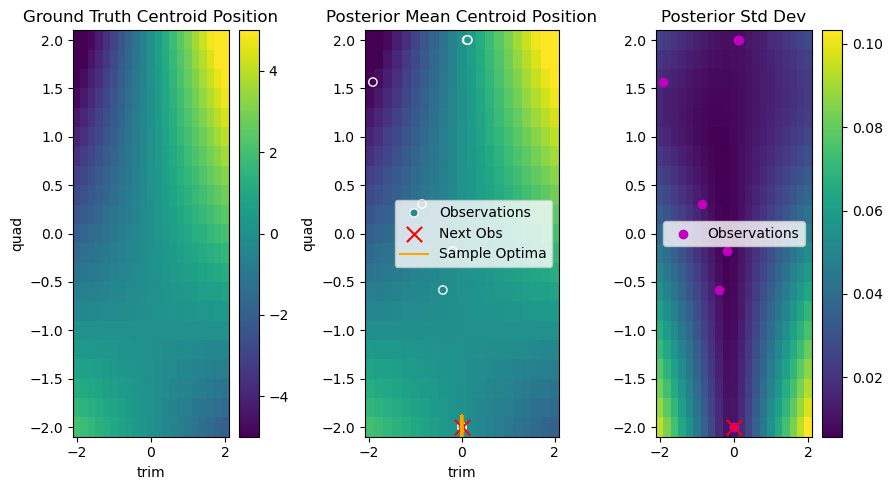

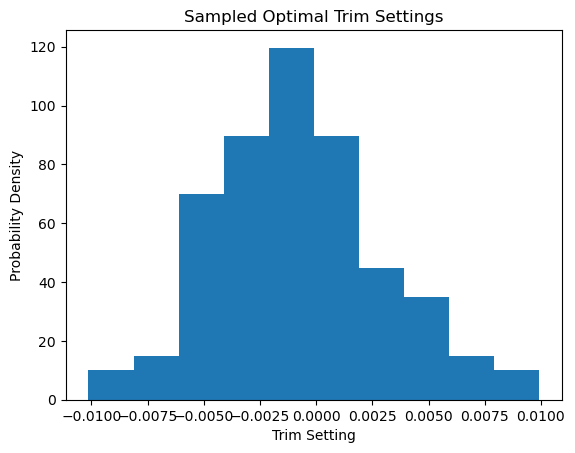



Iteration 7 



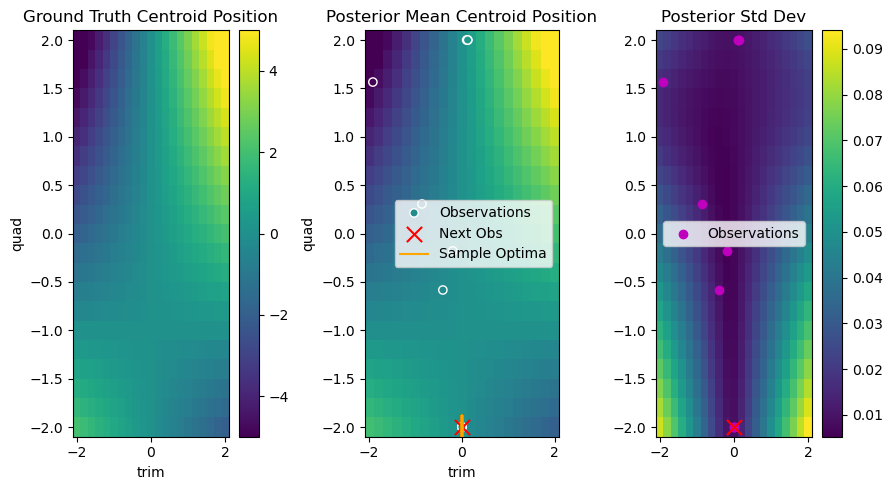

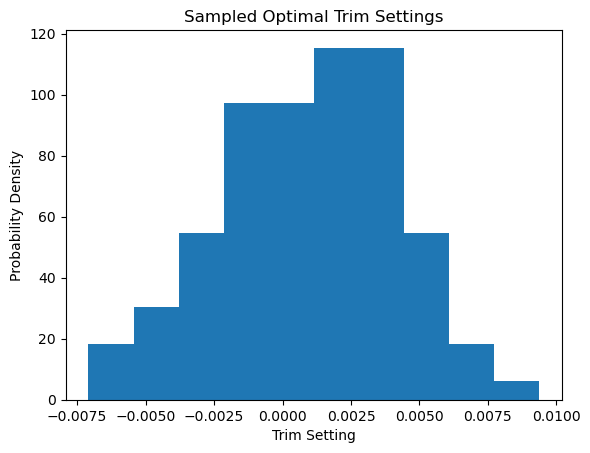



Iteration 8 



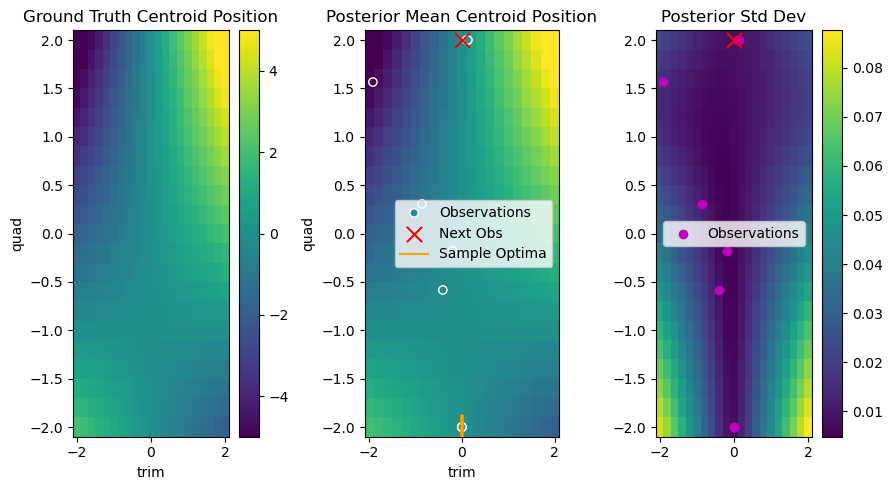

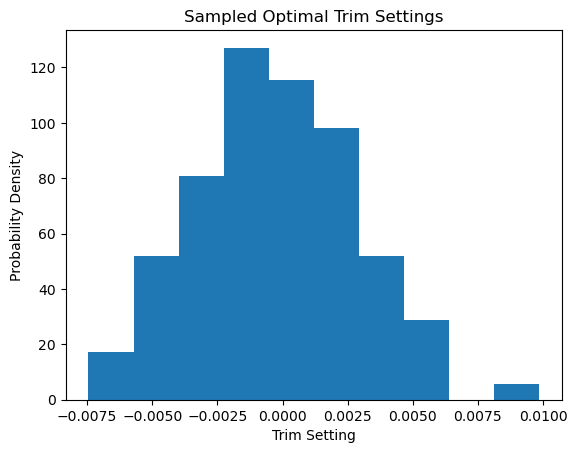



Iteration 9 



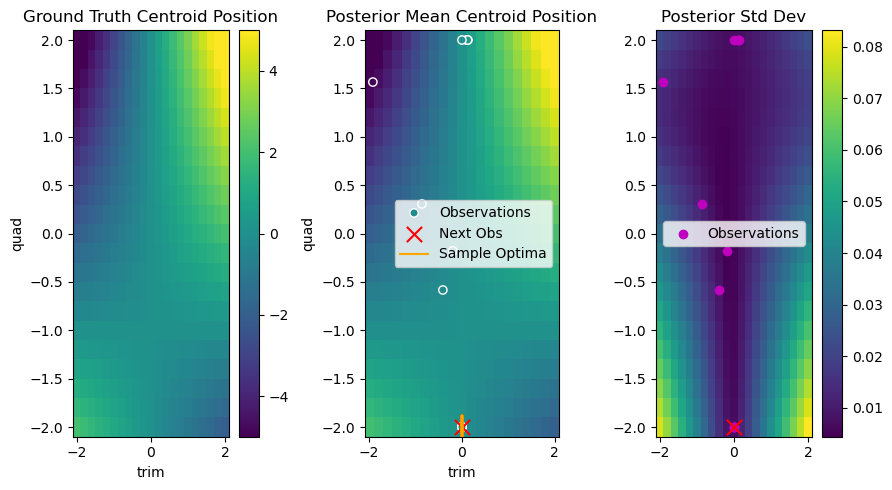

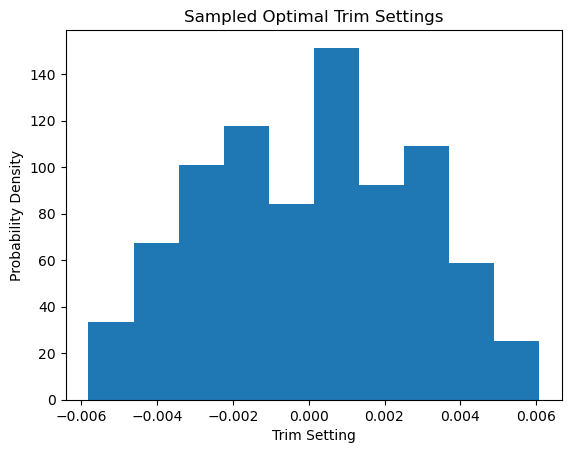

In [12]:
for i in range(10):
    print('\n\nIteration', i, '\n')
    optimizer.step()
#     X_stars = optimizer.generator.algo_results['X_stars']

    beam_centroid_model = optimizer.generator.model.models[0]

    ls = torch.linspace(-2,2,21)
    x0, x1 = torch.meshgrid(ls, ls)
    xmesh_serialized = torch.cat((x0.reshape(-1,1), x1.reshape(-1,1)), dim=1)
    ymesh_model = beam_centroid_model.posterior(xmesh_serialized).mean.reshape(21,21).detach()
    ymesh_model_var = beam_centroid_model.posterior(xmesh_serialized).variance.reshape(21,21).detach()
    ymesh_gt = centroid_position_at_screen(xmesh_serialized).reshape(21,21).detach()

    fig, axs = plt.subplots(1,3)
    fig.set_size_inches(9,5)

    ax = axs[0]
    c = ax.pcolormesh(x0, x1, ymesh_gt, vmin=-5, vmax=5)
    fig.colorbar(c)
    ax.set_xlabel('trim')
    ax.set_ylabel('quad')
    ax.set_title('Ground Truth Centroid Position')

    ax = axs[1]
    ax.pcolormesh(x0, x1, ymesh_model, vmin=-5, vmax=5)
    ax.set_xlabel('trim')
    ax.set_ylabel('quad')
    ax.set_title('Posterior Mean Centroid Position')
    ax.scatter(optimizer.data['x0'][:-1], optimizer.data['x1'][:-1], c=optimizer.data['y'][:-1], 
               vmin=-5, vmax=5, edgecolors='w', label='Observations')
    ax.scatter(optimizer.data['x0'][-1:], optimizer.data['x1'][-1:], c='r', 
               marker='x', s=120, label='Next Obs')

    X_stars = optimizer.generator.algorithm_results['X_stars']
    
    ax.axvline(X_stars.flatten()[0], c='orange', ymax=0.05, label='Sample Optima')
    for x_star in X_stars.flatten()[1:]:
        ax.axvline(x_star, c='orange', ymax=0.05)
    
    ax.legend()
    
    ax = axs[2]
    c = ax.pcolormesh(x0, x1, ymesh_model_var.sqrt())
    fig.colorbar(c)

    # for x_star in X_stars:
    #     ax.axvline(float(x_star), ymax=0.1, c='r')

    ax.scatter(optimizer.data['x0'][:-1], optimizer.data['x1'][:-1], c='m', label='Observations')
    ax.scatter(optimizer.data['x0'][-1:], optimizer.data['x1'][-1:], c='r', marker='x', s=120)
    ax.set_title('Posterior Std Dev')
    ax.legend()
    plt.tight_layout()
    plt.show()
    
    plt.hist(X_stars.flatten(), density=True)
    plt.title('Sampled Optimal Trim Settings')
    plt.xlabel('Trim Setting')
    plt.ylabel('Probability Density')
    plt.show()

In [13]:
optimizer.data

,x0,x1,y,xopt_runtime,xopt_error
1,-0.195254,-0.179533,-0.160200,0.000972,False
2,-0.860757,0.305381,-1.123616,0.000114,False
3,-0.411054,-0.583576,-0.171172,0.000079,False
4,-1.920112,1.565409,-4.925872,0.000108,False
5,0.102155,2.000000,0.306465,0.000146,False
6,0.128535,2.000000,0.385604,0.000119,False
7,0.122441,1.999998,0.367322,0.000157,False
8,0.002381,-2.000000,-0.002381,0.000136,False
9,-0.000739,-2.000000,0.000739,0.000149,False
10,-0.001976,-2.000000,0.001976,0.000112,False
